# Predicting Coding Languages

* Rich Alcabes
* Garrett Arnett
* Edward Michaud

## Our Goal

* Create a Classificatoin model which will predict what the primary programming language is in a github repository using Natural Language Processing techniques. 

## Our Plan

* Plan: Questions and Hypotheses
* Acquire: Create a dataset from github containing repositories that primarily use R and Python using web scraping. 
* Prepare: Kept outliers, removed null values and languages other than english. 
* Explore: 
* Model: 
* Deliver: Please refer to this doc as well as the Final_Report.ipynb file for the finished version of the presentation, in addition to a brief 5-min presentation to the DS Team.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette("tab10")
from scipy import stats
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
#CATboost imports
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import os
from langdetect import detect
seed = 1349
import unicodedata
import nltk
from bs4 import BeautifulSoup
import requests
from nltk.corpus import stopwords
import wrangle_g as wr
import re
import warnings
warnings.filterwarnings("ignore")
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-notebook')


## Acquire and Data Preperation

In [2]:
df = wr.prepare_mvp()
df

,repo,language,readme_contents
0,ujjwalkarn/DataScienceR,R,# R Data Science Tutorials\n- This repo contai...
1,IndrajeetPatil/ggstatsplot,R,---\noutput: github_document\n---\n\n <!-- RE...
2,easystats/easystats,R,"---\noutput: github_document\n---\n\n```{r, wa..."
3,seandavi/sars2pack,R,---\noutput: \n - rmarkdown::github_document\...
4,markvanderloo/lumberjack,R,## Track changes in data\n[![Build Status](htt...
...,...,...,...
350,rahulbordoloi/Machine-Learning,Python,# Machine-Learning\nContains my Glossary for M...
351,Oslandia/QDeeplandia,Python,QGIS plugin dedicated to 2D semantic segmentat...
352,arjunbhasin2013/BaselinePredictionMLFramework,Python,# Baseline Prediction Machine Learning Framewo...
353,PonderaLab/datascience4economists,Python,"# Datascience4economists\n\nFirst of all, welc..."


In [3]:
train, validate, test = wr.final_wrangle(df)

In [4]:
train.head()

,repo,language,readme_contents,stopped
102,TanShengRong/Cryptocurrency-Forecast,R,# DSBees\n\nR Shiny dashboard to analyze top 1...,dsbees shiny dashboard analyze top 10 cryptocu...
8,adityashrm21/Bike-Sharing-Demand-Kaggle,R,# Bike-Sharing-Demand---Kaggle\n\nSolution to ...,bikesharingdemandkaggle solution kaggle knowle...
126,vincenzorusso3/tesi-triennale,R,# PPMI Research\nThe main goal is to create a ...,ppmi research main goal create system order cl...
327,Tech-Matt/game_of_life,Python,# Game of Life\n\n## Premise\nThis is the firs...,game life premise first readme im write projec...
168,isrt09/Machine_Learning_with_R,R,# Machine Learning with R ( Supervised Learnin...,machine learn supervise learn data process &#9...


#### Steps taken to Prepare

* Acquire: Create a dataset from github containing repositories that primarily use R and Python using web scraping. 
* Prepare: Kept outliers, removed null values and languages other than english. 

|Feature |  Data type | Definition |
|---|---|---|
| Repo | String | Name of the repository on github |
| Language | String | Programming language of the repo |
| Readme_contents | String | Original readme content  |
| Stopped | String | Cleaned readme content |


## Explore

#### 1. Does a statistically significant difference exist between mean token_cnt of R language repos and that of Python language repos?


### Hypotheses:

- ${H_0}$: No statistically significant difference exists between mean token_cnt of R language repos and that of Python language repos.
- ${H_a}$: A statistically significant difference exists between mean token_cnt of R language repos and that of Python language repos.

In [5]:
wr.stat()

-2.08523550938645 0.03863565054208368 0.05
p = 0.0386


With a p-value less of .05, there is a statistically significant correlation that exists, there is evidence to suggest that there is a coorelation between token_cnt and R.

In [6]:
df = wr.prepare_mvp()
train, validate, test = wr.final_wrangle(df)
r_df = wr.clean(' '.join(train[train.language=='R']['stopped']))
python_df = wr.clean(' '.join(train[train.language=='Python']['stopped']))
all_df = wr.clean(' '.join(train['stopped']))
r_freq = pd.Series(r_df).value_counts()
python_freq = pd.Series(python_df).value_counts()
all_freq = pd.Series(all_df).value_counts()
word_counts = pd.concat([r_freq, python_freq,all_freq], axis=1
         ).fillna(0
                 ).astype(int)
word_counts.columns = ['r', 'python' ,'all']


Text(0, 0.5, 'Words')

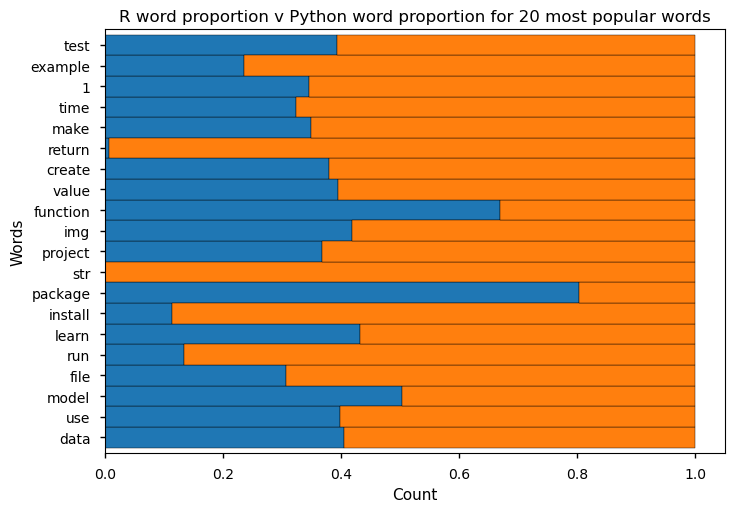

In [7]:
word_counts.sort_values('all', ascending=False
                       ).head(20).apply(
    lambda row: row/row['all'], axis=1
)[['r','python']].plot.barh(
    stacked=True, legend=False, ec='black', 
    width=1).set(title='R word proportion v Python word proportion for 20 most popular words');
plt.xlabel('Count')

plt.ylabel('Words')

XXXXXXXXXXXXXX

Text(0, 0.5, 'Words')

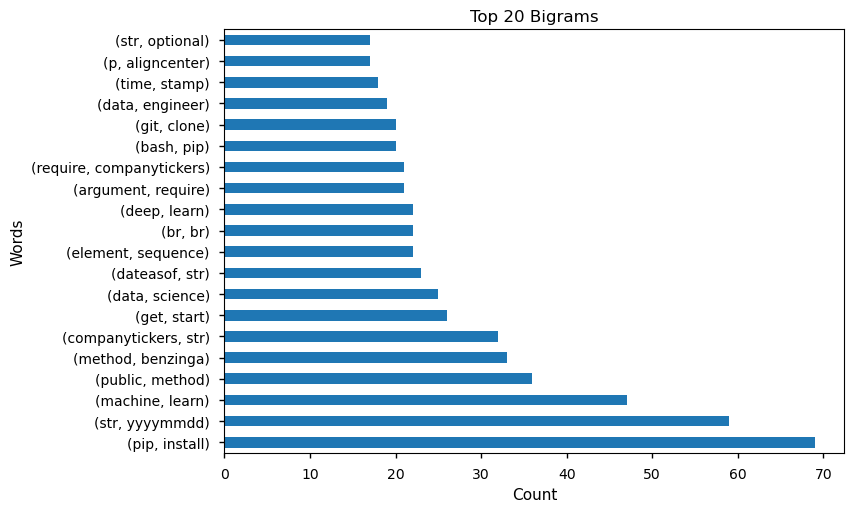

In [8]:
pd.Series(nltk.bigrams(python_df)).value_counts().head(20).plot.barh()
plt.title('Top 20 Bigrams')
plt.xlabel('Count')
plt.ylabel('Words')

XXXXXXXXXXX

Text(0, 0.5, 'Words')

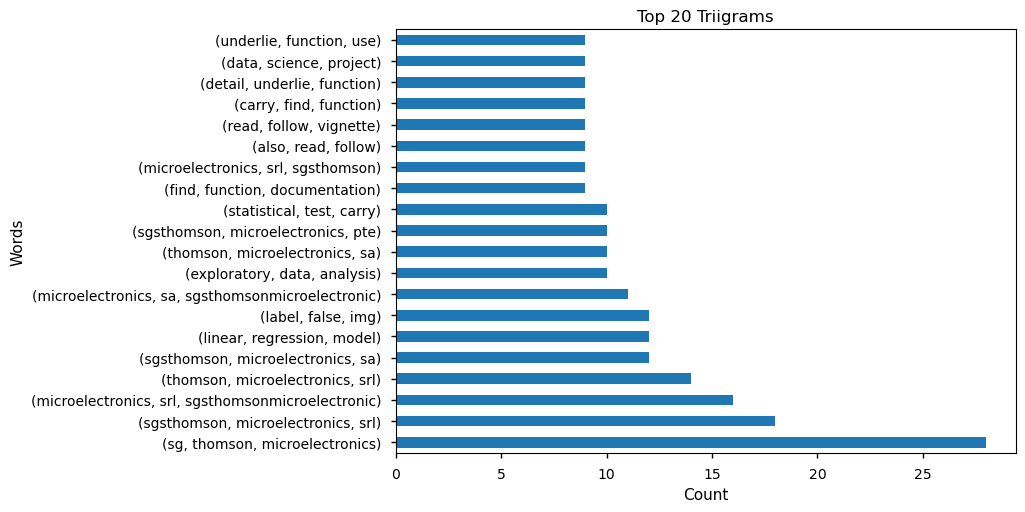

In [9]:
pd.Series(nltk.ngrams(r_df, 3)
         ).value_counts().head(20).plot.barh()
plt.title('Top 20 Triigrams')
plt.xlabel('Count')
plt.ylabel('Words')

XXXXXXXXXXXXXX

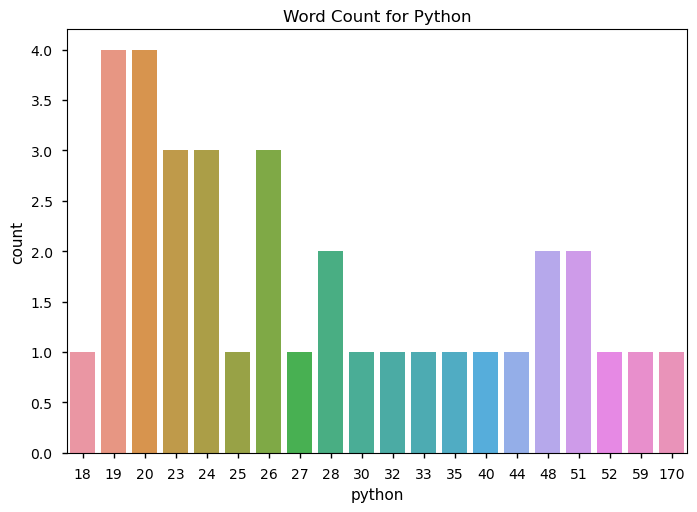

In [10]:
r_df = train[train.language=='R']
python_df = train[train.language=='Python']
r_words = ' '.join(r_df['stopped']).split()
python_words = ' '.join(python_df['stopped']).split()
all_words = ' '.join(train['stopped']).split()
python_words = word_counts[(word_counts['r'] == 0)&(word_counts['python'] >= 10)].head(35)
sns.countplot(data=python_words, x=python_words['python'])
plt.title('Word Count for Python')
plt.show()

XXXXXXXXXXXXXXXX

Text(0.5, 1.0, 'Word Count for R')

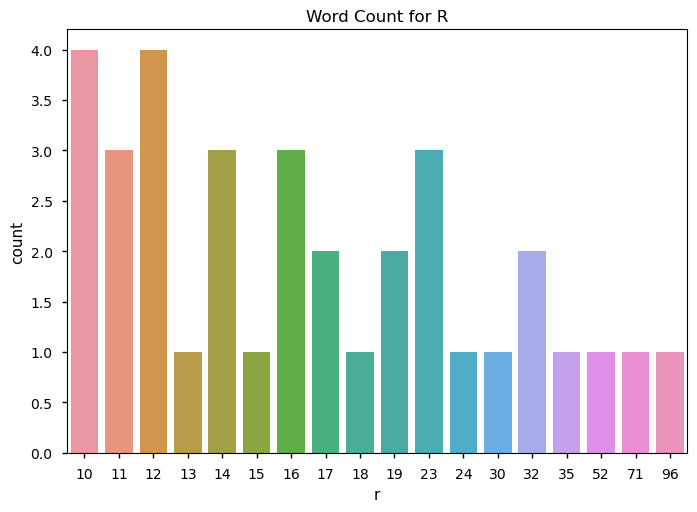

In [11]:
r_words = word_counts[(word_counts['python'] == 0)&(word_counts['r'] >= 10)].head(35)
sns.countplot(data=r_words, x=r_words['r'])
plt.title('Word Count for R')

XXXXXXXXXXXXXX

## Explore Takaways

*
*
*
*
*


# Modeling

### Baseline:

In [12]:

# ESTABLISH BASELINE:
df = pd.get_dummies(df, columns=['language'], drop_first=True)
df.language_R.value_counts()
df['baseline'] = 0
baseline_accuracy = (df.baseline == df.language_R).mean()
print(f'baseline accuracy: {baseline_accuracy:.2%}')

baseline accuracy: 57.79%


## Train/Valitdate/Test Split

In [13]:
train, validate, test = wr.final_wrangle(wr.prepare_mvp())

In [14]:
train['token_cnt'] = [len(row['stopped'].split()) for _, row in train.iterrows()]
train.rename(columns = {'language':'language_R'}, inplace = True)
validate.rename(columns = {'language':'language_R'}, inplace = True)
test.rename(columns = {'language':'language_R'}, inplace = True)
train = train.drop(columns=['repo','readme_contents'])
validate = validate.drop(columns=['repo','readme_contents'])
test = test.drop(columns=['repo','readme_contents'])

XXXXXXXXXXXXXXX

## Create X and y train/validate/test

In [15]:
    # split train into X (dataframe, drop target) & y (series, keep target only)
    X_train = train['stopped']
    y_train = train['language_R']
    
    # split validate into X (dataframe, drop target) & y (series, keep target only)
    X_validate = validate['stopped']
    y_validate = validate['language_R']
    
    # split test into X (dataframe, drop target) & y (series, keep target only)
    X_test = test['stopped']
    y_test = test['language_R']
    
    tfidf = TfidfVectorizer()
    X_bow = tfidf.fit_transform(X_train)

## How we create the models:

We use four different regressors:


* DTC maxDepth = 4
* RFC maxDepth=6
* GDTC maxDepth = 4 TEST
* BIGRAMS with DTC mD=4


### Decision Tree Classifier

In [16]:
wr.dtc_model()

Accuracy-Train 0.821
Accuracy-Validate 0.7714
              precision    recall  f1-score   support

      Python       1.00      0.69      0.82        93
           R       0.70      1.00      0.83        69

    accuracy                           0.82       162
   macro avg       0.85      0.84      0.82       162
weighted avg       0.87      0.82      0.82       162

              precision    recall  f1-score   support

      Python       0.90      0.68      0.77        40
           R       0.68      0.90      0.77        30

    accuracy                           0.77        70
   macro avg       0.79      0.79      0.77        70
weighted avg       0.80      0.77      0.77        70



XXXXXXX

### Random Forest Classifier maxDepth=6

In [17]:
wr.rfc()

Accuracy-Train 0.6667
Accuracy-Validate 0.5857
              precision    recall  f1-score   support

      Python       0.63      1.00      0.78        93
           R       1.00      0.22      0.36        69

    accuracy                           0.67       162
   macro avg       0.82      0.61      0.57       162
weighted avg       0.79      0.67      0.60       162

              precision    recall  f1-score   support

      Python       0.58      1.00      0.73        40
           R       1.00      0.03      0.06        30

    accuracy                           0.59        70
   macro avg       0.79      0.52      0.40        70
weighted avg       0.76      0.59      0.45        70



XXXXXXX

### DTC maxDepth = 6 TEST

In [18]:
wr.gdtc()

Accuracy-Train 0.8827
Accuracy-Validate 0.7429
              precision    recall  f1-score   support

      Python       1.00      0.80      0.89        93
           R       0.78      1.00      0.88        69

    accuracy                           0.88       162
   macro avg       0.89      0.90      0.88       162
weighted avg       0.91      0.88      0.88       162

              precision    recall  f1-score   support

      Python       0.84      0.68      0.75        40
           R       0.66      0.83      0.74        30

    accuracy                           0.74        70
   macro avg       0.75      0.75      0.74        70
weighted avg       0.76      0.74      0.74        70



XXXXXXX

### BIGRAMS with DTC mD=4

In [19]:
wr.bgram()

Accuracy-Train 0.7469
Accuracy-Validate 0.7857
              precision    recall  f1-score   support

      Python       1.00      0.56      0.72        93
           R       0.63      1.00      0.77        69

    accuracy                           0.75       162
   macro avg       0.81      0.78      0.74       162
weighted avg       0.84      0.75      0.74       162

              precision    recall  f1-score   support

      Python       1.00      0.62      0.77        40
           R       0.67      1.00      0.80        30

    accuracy                           0.79        70
   macro avg       0.83      0.81      0.78        70
weighted avg       0.86      0.79      0.78        70



XXXXXXX

### print test predictions to .csv

In [21]:
wr.prediction_csv()

## Modeling summary

Observation of prediction results led me to the following conclusions:

*

*

*


# Conclusions

*
*


# Next Steps

*
*
*
